Importing all the necessary libraries


In [ ]:
 import pandas as pd  # df processing, CSV file I/O (e.g. pd.read_csv)
 import numpy as np  # linear algebra

In [ ]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py


--2023-03-04 08:29:52--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py.1’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0s      

2023-03-04 08:29:52 (90.4 MB/s) - ‘helper_prabowo_ml.py.1’ saved [13881/13881]



In [ ]:
!pip install transformers   #import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

In [ ]:
# reading the give data

train = pd.read_csv('/content/train.txt', names = ['Input', 'Sentiment'], sep =';', encoding = 'utf-8')
val = pd.read_csv("/content/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("/content/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

In [ ]:
df = pd.concat([train, test, val], axis=0)

df.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()


,index,Input,Sentiment
0,1596,i feel uncomfortable with the fact i am so pow...,fear
1,12393,i wont feel so damn idiotic,sadness
2,6792,i feel ignored and invisible so every weekend ...,sadness
3,12080,i feel like ive been fairly successful,joy
4,9440,i feel like the cute little case is kind of hi...,joy


In [ ]:
df.drop('index',axis=1,inplace=True)


In [ ]:
df.head()

,Input,Sentiment
0,i feel uncomfortable with the fact i am so pow...,fear
1,i wont feel so damn idiotic,sadness
2,i feel ignored and invisible so every weekend ...,sadness
3,i feel like ive been fairly successful,joy
4,i feel like the cute little case is kind of hi...,joy


In [ ]:
df.shape

(3400, 2)

Text Preprocessing

In [ ]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data


In [ ]:
df['Input']

0       i feel uncomfortable with the fact i am so pow...
1                             i wont feel so damn idiotic
2       i feel ignored and invisible so every weekend ...
3                  i feel like ive been fairly successful
4       i feel like the cute little case is kind of hi...
                              ...                        
3395    i done something that i didn t feel inspired o...
3396    ive been feeling weirdly superior about my kno...
3397    i feel so repressed when compared to dear a hr...
3398    i started the third block feeling hot and cold...
3399    i remember feeling humiliated because of the p...
Name: Input, Length: 3400, dtype: object

In [ ]:
df['Sentiment'].value_counts()

joy         1145
sadness      973
anger        467
fear         412
love         271
surprise     132
Name: Sentiment, dtype: int64

In [ ]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,feel uncomfortable fact powerless moment,fear
1,wont feel damn idiotic,sadness
2,feel ignored invisible every weekend miserable,sadness
3,feel ive fairly successfu,joy
4,feel cute little case kind hidde,joy


In [ ]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)


In [ ]:
preprocessed_df.head()


,Input,Sentiment,num_words
0,feel uncomfortable fact powerless moment,fear,40
1,wont feel damn idiotic,sadness,22
2,feel ignored invisible every weekend miserable,sadness,46
3,feel ive fairly successfu,joy,25
4,feel cute little case kind hidde,joy,32


In [ ]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 


In [ ]:
preprocessed_df.head()


,Input,Sentiment,num_words
0,feel uncomfortable fact powerless moment,fear,40
1,wont feel damn idiotic,sadness,22
2,feel ignored invisible every weekend miserable,sadness,46
3,feel ive fairly successfu,joy,25
4,feel cute little case kind hidde,joy,32


Train-Test Split

In [ ]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)


Loading the Tokenizer class and pretrained BERT model¶


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


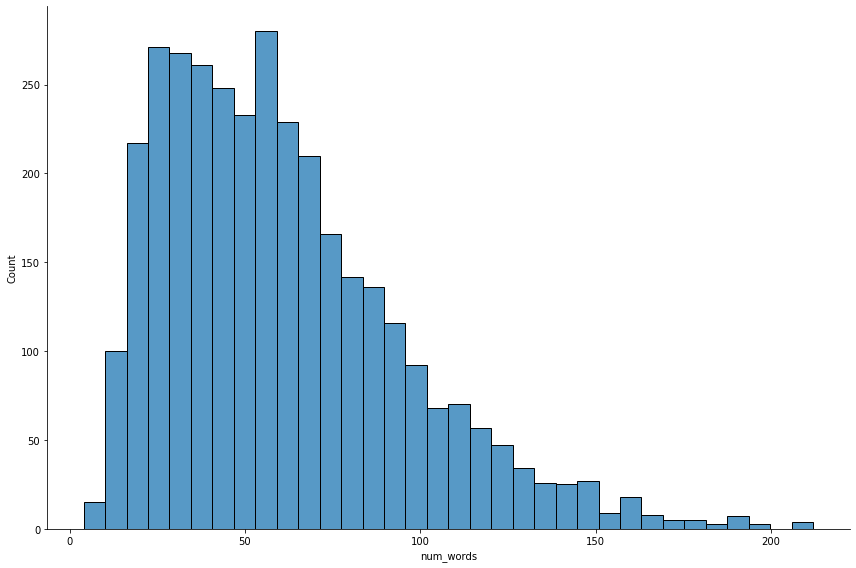

In [ ]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)


In [ ]:
max_len = 40


Text Tokenization

In [ ]:
x_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

x_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

Defining the model architecture


In [ ]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)


In [ ]:
input_ids

<KerasTensor: shape=(None, 40) dtype=int32 (created by layer 'input_ids')>

In [ ]:
attention_mask

<KerasTensor: shape=(None, 40) dtype=int32 (created by layer 'attention_mask')>

In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

Compiling the model


In [ ]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

Encoding the emotion labels


In [ ]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)


In [ ]:
train_data['Label']

649     0
2707    2
56      1
1836    2
2976    2
       ..
2993    0
2666    4
3054    4
1542    2
59      4
Name: Label, Length: 2380, dtype: int64

In [ ]:
train_data.head()


,Input,Sentiment,num_words,Label
649,mean feel always someone else people becuase w...,anger,75,0
2707,think writing fun fulfilling think decide intr...,joy,89,2
56,feel strange weird entire struggle one deals k...,fear,58,1
1836,tested tried feel confident making bold statem...,joy,78,2
2976,spent days problem feeling eager finish job pl...,joy,128,2


In [ ]:
test_data.head()


,Input,Sentiment,num_words,Label
246,otice worrying push feeling away replace thoug...,joy,88,2
2944,began feel agitated wanted buy ewan food medic...,anger,54,0
1193,definitely feel appreciative boyfriend,joy,38,2
2302,originals want rebekah satisfactory ending sha...,love,89,3
221,eaving feel inadaquate valued appreciated,joy,41,2


Generating the model summary and plot


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                            

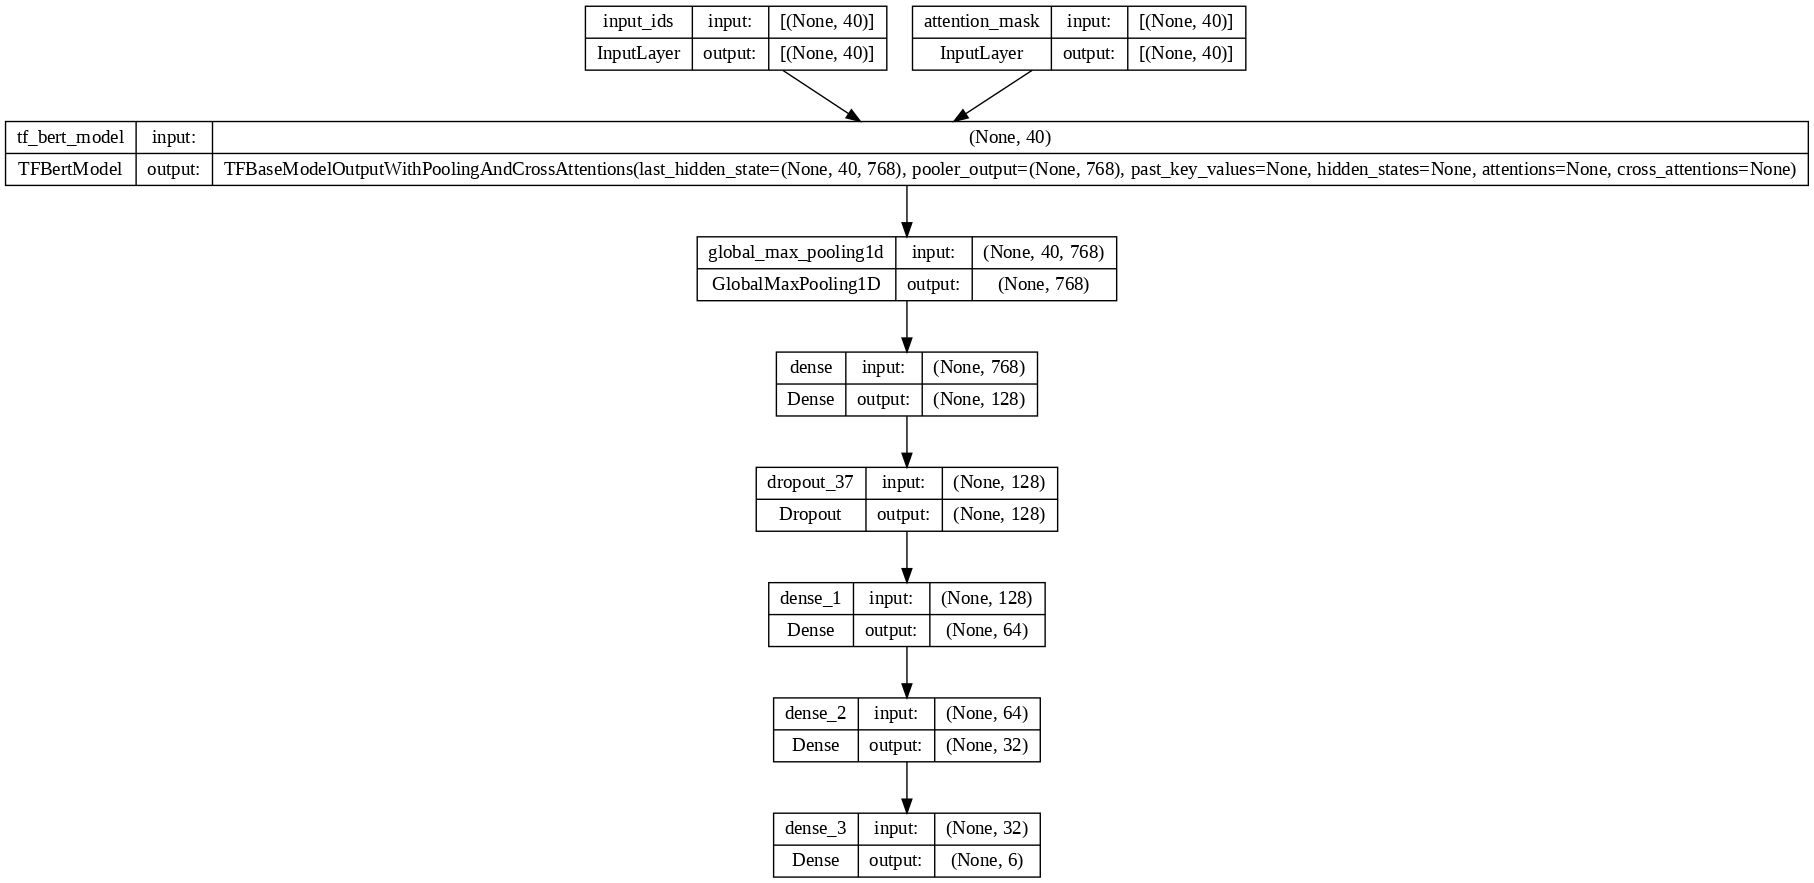

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

Training and fine-tuning the pretrained BERT model


In [ ]:
r = model.fit(x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']},to_categorical(test_data.Label)))


Epoch 1/10


75/75 [==============================] - 1448s 18s/step - loss: 1.4460 - balanced_accuracy: 0.4559 - val_loss: 1.0536 - val_balanced_accuracy: 0.6127
Epoch 2/10
75/75 [==============================] - 1339s 18s/step - loss: 0.8235 - balanced_accuracy: 0.7294 - val_loss: 0.5346 - val_balanced_accuracy: 0.8314
Epoch 3/10
75/75 [==============================] - 1336s 18s/step - loss: 0.3960 - balanced_accuracy: 0.8815 - val_loss: 0.3978 - val_balanced_accuracy: 0.8843
Epoch 4/10
75/75 [==============================] - 1328s 18s/step - loss: 0.2089 - balanced_accuracy: 0.9445 - val_loss: 0.3517 - val_balanced_accuracy: 0.9020
Epoch 5/10
75/75 [==============================] - 1322s 18s/step - loss: 0.1309 - balanced_accuracy: 0.9660 - val_loss: 0.3649 - val_balanced_accuracy: 0.9029
Epoch 6/10
75/75 [==============================] - 1265s 17s/step - loss: 0.0903 - balanced_accuracy: 0.9769 - val_loss: 0.4074 - val_balanced_accuracy: 0.8931
Epoch 7/10
75/75 [===========================

Analyzing model performance


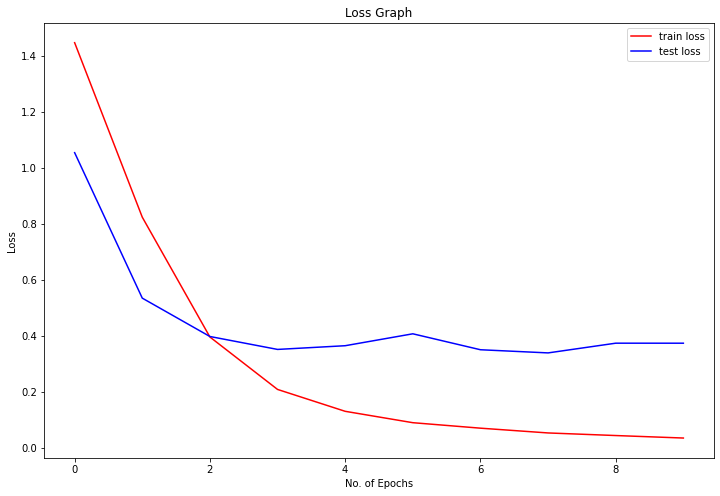

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();


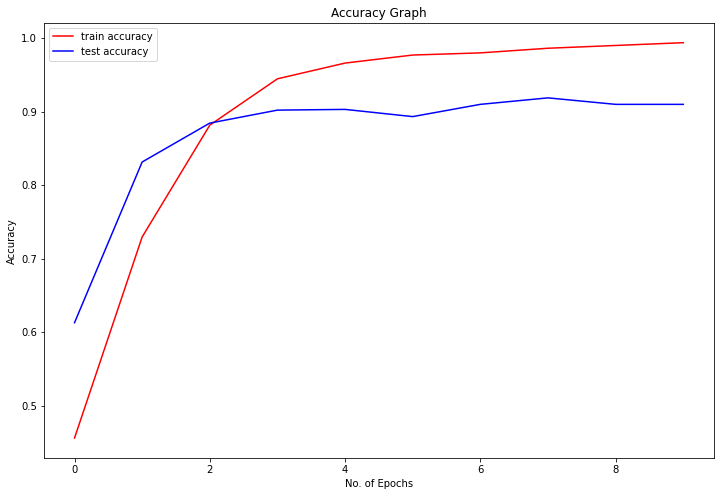

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

Saving the model


In [ ]:
model.save("emotion_detector.h5")


Evaluating the model on the test dataset


In [ ]:
loss, acc = model.evaluate({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

32/32 [==============================] - 177s 5s/step - loss: 0.3738 - balanced_accuracy: 0.9098
Test Categorical Cross-Entropy Loss: 0.3738430440425873
Test Categorical Accuracy: 0.9098039269447327


In [ ]:
test_predictions = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

32/32 [==============================] - 169s 5s/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       140
           1       0.90      0.90      0.90       124
           2       0.93      0.92      0.93       343
           3       0.82      0.86      0.84        81
           4       0.95      0.91      0.93       292
           5       0.71      0.88      0.79        40

    accuracy                           0.91      1020
   macro avg       0.87      0.90      0.88      1020
weighted avg       0.91      0.91      0.91      1020

